In [1]:
import kagglehub
from pathlib import Path
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# ============= 데이터 다운로드 & 기본 경로 =============

# 1) KaggleHub로 데이터셋 다운로드
path = kagglehub.dataset_download("sadhliroomyprime/football-semantic-segmentation")
print("Path to dataset files:", path)

DATA_ROOT = Path(path)
IMAGE_DIR = DATA_ROOT / "images"

# 2) 폴더 내 파일 목록 가져오기
file_list = os.listdir(IMAGE_DIR)

# 원본 이미지(.jpg, 'fuse' 없는 것)와 마스크 이미지('fuse' 포함된 .jpg) 분리
original_files = sorted([f for f in file_list if (f.endswith(".jpg") or f.endswith(".png")) and "fuse" not in f and "save" not in f])
fuse_files     = sorted([f for f in file_list if (f.endswith(".jpg") or f.endswith(".png")) and "fuse" in f])
save_files    = sorted([f for f in file_list if (f.endswith(".jpg") or f.endswith(".png")) and "save" in f])

print("원본 이미지 개수:", len(original_files))
print("마스크(fuse) 이미지 개수:", len(fuse_files))
print("저장(save) 이미지 개수:", len(save_files))

/opt/anaconda3/envs/yolo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/youuchul/.cache/kagglehub/datasets/sadhliroomyprime/football-semantic-segmentation/versions/1
원본 이미지 개수: 100
마스크(fuse) 이미지 개수: 100
저장(save) 이미지 개수: 100


In [2]:
# ============= 원본-마스크 매칭 & 딕셔너리 구성 =============

keys = []          # 각 샘플의 경로 딕셔너리 용도 key list, 원본 이미지 파일 이름으로 설정 (예: "Frame 1 (1).jpg")
image_dict = {}    # key -> 원본 이미지 경로
mask_dict  = {}    # key -> fuse 마스크 경로

for img_file in original_files:
    # 1) base_name: 원본 파일 이름 자체를 key로 사용
    #    예: "Frame 1 (1).jpg"
    sample_key = img_file

    # 2) 같은 원본을 시작으로 하는 fuse 파일 찾기
    #    예: "Frame 1 (1).jpg___fuse.png"
    fuse_file = next(
        (f for f in fuse_files if f.startswith(sample_key)),
        None
    )

    # 3) 해당하는 fuse 파일이 없으면 건너뛴다 (이론상 없으면 안 되지만 안전장치)
    if fuse_file is None:
        # print(f"[WARN] no fuse for {img_file}")
        continue

    # 4) key 하나 정하고, 경로를 Path 객체로 만들어서 dict에 저장

    keys.append(sample_key) # "Frame 1 (1).jpg"
    image_dict[sample_key] = IMAGE_DIR / img_file    # /.../images/Frame 1 (1).jpg
    mask_dict[sample_key]  = IMAGE_DIR / fuse_file    # /.../images/Frame 1 (1).jpg___fuse.png

print("최종 매칭된 샘플 개수:", len(keys))

최종 매칭된 샘플 개수: 100


In [3]:
from sklearn.model_selection import train_test_split

# keys 리스트를 80% / 20%로 나누기 (데이터 수가 100개로 적고 코드 및 학습 루프 복잡성 증가하므로 validation set 별도 만들지 않음, 랜덤 시드 42 고정)
train_keys, test_keys = train_test_split(keys, test_size=0.2, random_state=42)

print("train:", len(train_keys))
print("test:", len(test_keys))

train: 80
test: 20


- 베이스라인이나 기존 작업과 달리 Dataset 내부 인덱스로 random_split을 진행하지 않고, 파일이름(keys) 리스트에 train_test_split을 진행   
 (이후 명시적 mapping 예정)
- 앞선 프로젝트에서 데이터셋 분리/로더/증강 에서 오류가 유발되어, 매칭 안정성과 디버깅 용이성을 고려하여 설정함

### 어노테이션 파일 탐색

In [4]:
print(os.listdir(DATA_ROOT))

['images', 'www.acmeai.tech ODataset 3 - Football Semantic Segmentation.pdf', 'About Acme AI.txt', 'COCO_Football Pixel.json']


- .json 파일 형태 확인

In [5]:
import json

json_path = DATA_ROOT / "COCO_Football Pixel.json"

with open(json_path, "r") as f:
    coco = json.load(f)

print(coco.keys())

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [6]:
# 카테고리 몇 개 있는지 확인
print("num categories:", len(coco["categories"]))

# 앞 몇 개만 찍어보기
for cat in coco["categories"]:
    print(cat)

num categories: 11
{'id': 1393250, 'name': 'Goal Bar', 'supercategory': 'Goal Bar', 'isthing': 1, 'color': [98, 66, 21]}
{'id': 1392807, 'name': 'Referee', 'supercategory': 'Referee', 'isthing': 1, 'color': [167, 64, 21]}
{'id': 1392806, 'name': 'Advertisements', 'supercategory': 'Advertisements', 'isthing': 1, 'color': [166, 64, 21]}
{'id': 1392805, 'name': 'Ground', 'supercategory': 'Ground', 'isthing': 1, 'color': [165, 64, 21]}
{'id': 1392804, 'name': 'Ball', 'supercategory': 'Ball', 'isthing': 1, 'color': [164, 64, 21]}
{'id': 1392803, 'name': 'Coaches & Officials', 'supercategory': 'Coaches & Officials', 'isthing': 1, 'color': [163, 64, 21]}
{'id': 1392802, 'name': 'Audience', 'supercategory': 'Audience', 'isthing': 1, 'color': [162, 64, 21]}
{'id': 1392801, 'name': 'Goalkeeper B', 'supercategory': 'Goalkeeper B', 'isthing': 1, 'color': [161, 64, 21]}
{'id': 1392800, 'name': 'Goalkeeper A', 'supercategory': 'Goalkeeper A', 'isthing': 1, 'color': [160, 64, 21]}
{'id': 1392799, 'na

- id, 클래스명, 컬러만 별도로 리스팅

In [7]:
for idx, cat in enumerate(coco["categories"]):
    print(idx, cat["id"], cat["name"], cat["color"])

0 1393250 Goal Bar [98, 66, 21]
1 1392807 Referee [167, 64, 21]
2 1392806 Advertisements [166, 64, 21]
3 1392805 Ground [165, 64, 21]
4 1392804 Ball [164, 64, 21]
5 1392803 Coaches & Officials [163, 64, 21]
6 1392802 Audience [162, 64, 21]
7 1392801 Goalkeeper B [161, 64, 21]
8 1392800 Goalkeeper A [160, 64, 21]
9 1392799 Team B [159, 64, 21]
10 1392794 Team A [154, 64, 21]


- COCO 어노테이션 파일의 id는 RGB 값음 정수로 인코딩하여 넘버링한다.  
 (해당 프로젝트 주제와 거리가 있어, 별도 스터디 후 정리하여 github에 저장함)
- 리스팅한 컬러값을 실제 마스크이미지.png의 컬러값과 비교.

In [ ]:
from PIL import Image
import numpy as np

# 전체 마스크에서 쓰이는 색(RGBA) 모두 수집
all_colors = set()

for mask_path in mask_dict.values():
    mask_img = Image.open(mask_path)

    # 이미지 전체 픽셀에서 색 추출 (count, color) 리스트
    colors = mask_img.getcolors(maxcolors=9_999_999)
    if colors is None:
        raise ValueError("색 개수가 너무 많음 (팔레트 마스크 이미지가 아님).")

    for cnt, color in colors:
        # color: (R,G,B,A) 튜플
        all_colors.add(color)

print("전체 색 개수:", len(all_colors))

# RGBA 튜플을 정렬해서 “고정 팔레트” 만들기
colors_rgba = sorted(all_colors)

print("\n정렬된 색 리스트 (index → color):")
for idx, c in enumerate(colors_rgba):
    print(idx, c)

전체 색 개수: 11

정렬된 색 리스트 (index → color):
0 (0, 0, 0, 255)
1 (27, 71, 151, 255)
2 (111, 48, 253, 255)
3 (137, 126, 126, 255)
4 (201, 19, 223, 255)
5 (238, 171, 171, 255)
6 (254, 233, 3, 255)
7 (255, 0, 29, 255)
8 (255, 159, 0, 255)
9 (255, 160, 1, 255)
10 (255, 235, 0, 255)


- 어노테이션 컬러값과 매칭되지 않음, 직접 시각화 하여 컬러값을 오브젝트와 매칭 시도


=== Color #0 (0, 0, 0, 255) ===
  -> Found in mask file: Frame 1  (10).jpg


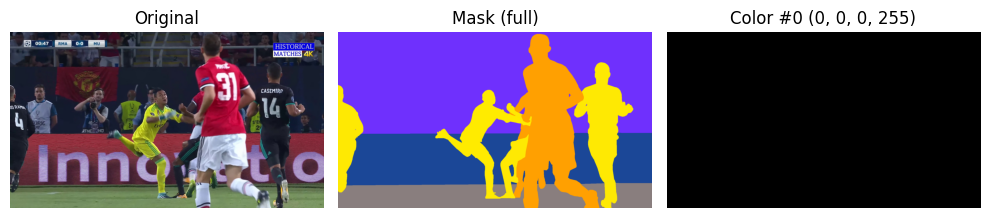


=== Color #1 (27, 71, 151, 255) ===
  -> Found in mask file: Frame 1  (1).jpg


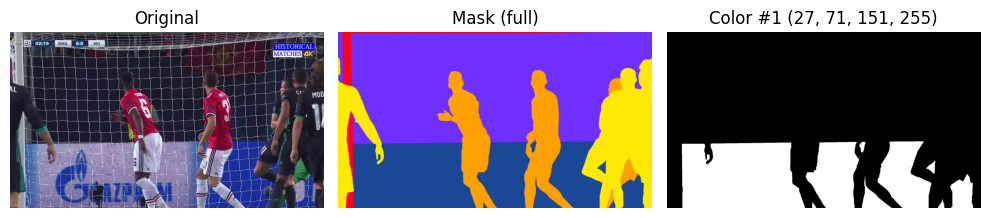


=== Color #2 (111, 48, 253, 255) ===
  -> Found in mask file: Frame 1  (1).jpg


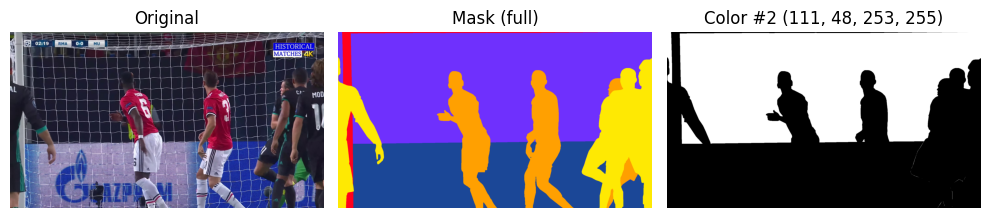


=== Color #3 (137, 126, 126, 255) ===
  -> Found in mask file: Frame 1  (10).jpg


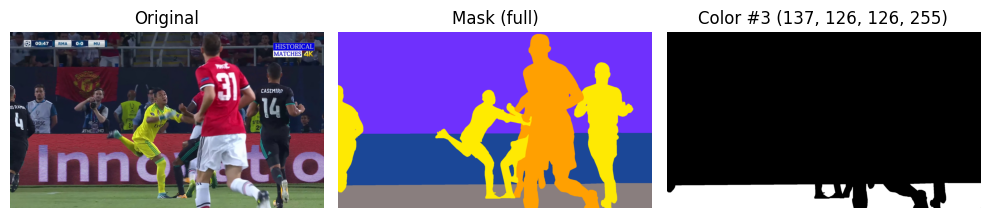


=== Color #4 (201, 19, 223, 255) ===
  -> Found in mask file: Frame 1  (100).jpg


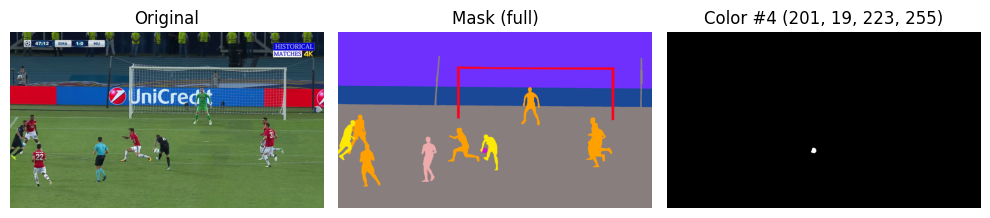


=== Color #5 (238, 171, 171, 255) ===
  -> Found in mask file: Frame 1  (100).jpg


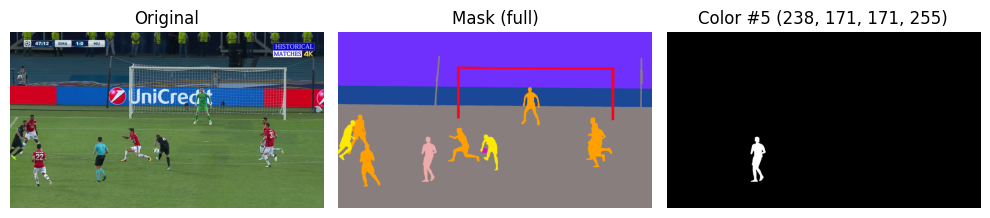


=== Color #6 (254, 233, 3, 255) ===
  -> Found in mask file: Frame 1  (1).jpg


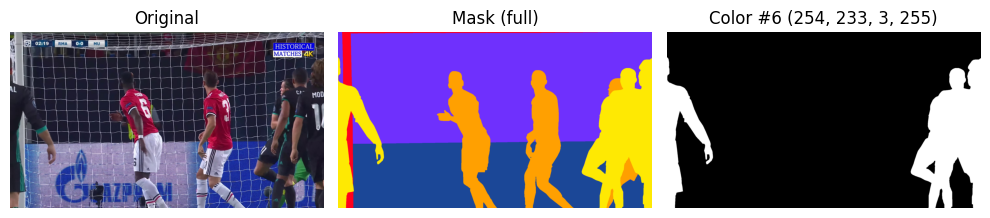


=== Color #7 (255, 0, 29, 255) ===
  -> Found in mask file: Frame 1  (1).jpg


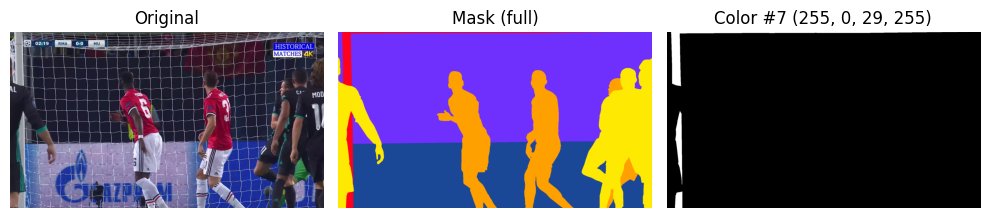


=== Color #8 (255, 159, 0, 255) ===
  -> Found in mask file: Frame 1  (1).jpg


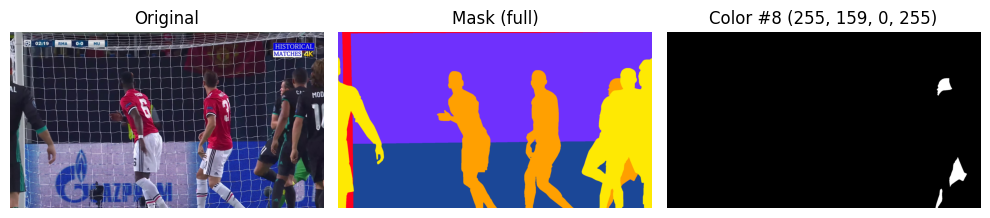


=== Color #9 (255, 160, 1, 255) ===
  -> Found in mask file: Frame 1  (1).jpg


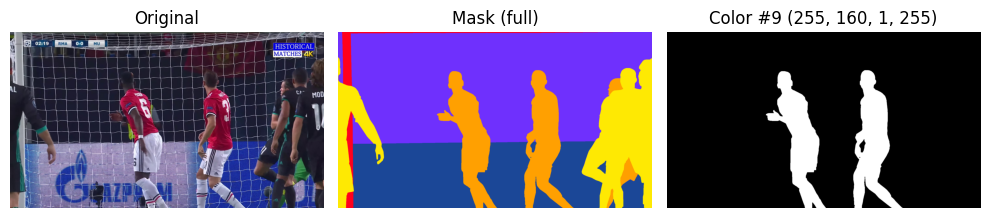


=== Color #10 (255, 235, 0, 255) ===
  -> Found in mask file: Frame 1  (10).jpg


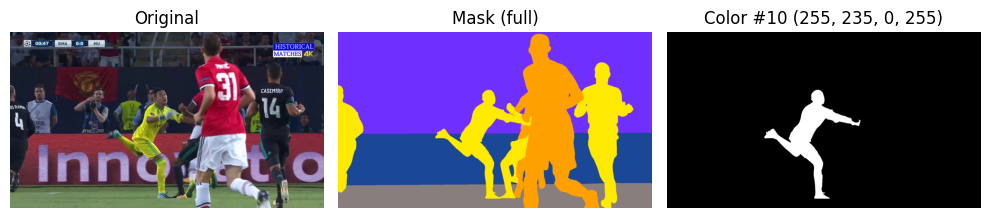

In [9]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 바깥 루프: 색 인덱스 0 ~ N-1 순서대로
for idx, color in enumerate(colors_rgba):
    color_np = np.array(color, dtype=np.uint8)
    found = False  # 이 색을 가진 마스크를 찾았는지 여부

    # 안쪽 루프: 모든 마스크 파일을 순회하면서 해당 색이 있는 프레임 찾기
    for sample_key in keys:
        mask = Image.open(mask_dict[sample_key]).convert("RGBA")
        mask_np = np.array(mask)

        # 이 색과 정확히 일치하는 픽셀 위치 (H,W) bool
        match = np.all(mask_np == color_np, axis=-1)

        if not match.any():
            continue  # 이 마스크에는 이 색 없음 → 다음 파일

        # 여기까지 오면: 이 sample_key 마스크에 color가 실제로 존재
        print(f"\n=== Color #{idx} {color} ===")
        print(f"  -> Found in mask file: {sample_key}")

        plt.figure(figsize=(10,3))

        # 1) 원본 이미지
        plt.subplot(1,3,1)
        plt.imshow(Image.open(image_dict[sample_key]))
        plt.title("Original")
        plt.axis("off")

        # 2) 전체 마스크
        plt.subplot(1,3,2)
        plt.imshow(mask)
        plt.title("Mask (full)")
        plt.axis("off")

        # 3) 해당 색만 하이라이트 (binary mask)
        plt.subplot(1,3,3)
        plt.imshow(match, cmap="gray")
        plt.title(f"Color #{idx} {color}")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        found = True
        break  # 이 색은 한 번만 보여주면 되니까 다음 색으로

    if not found:
        print(f"\n=== Color #{idx} {color} 는 어떤 마스크에도 없음 ===")

- 실제 이미지 -> 명칭으로 수동 매칭은 가능하지만, 팀 A/B, 골키퍼 A/B는 해당 이미지만으로 매칭불가
- 어노테이션 기준으로 새롭게 마스킹한후 4장을 함께 비교하는 것도 가능하겠지만, 일단 보류   
 (모델 분류 학습/평가는 클래스명 매칭 없이 가능)
- 추출했던 컬러값 중 (0,0,0,255)는 이미지 내에서 확인되지 않는 마스킹 이미지에 보이지 않는 값   
 (데이터셋 참고 자료에서도 Coaches & Officials는 비중 0% 확인 : 추출된 컬러 값이 10개여야 함)

> 클래스명 기준 매칭이 아닌 고유 컬러값으로 우선 진행 (데이터로더 정의 및 후속 작업)